# Detecting Freezing of Gait (FOG) with Convolutionnal Neural Network

**Daphnet Freezing of Gait Dataset in users with Parkinson's disease**

The Daphnet Freezing of Gait Dataset Freezing of Gait in users with Parkinson disease (hereafter Daphnet Freezing of Gait Dataset) is a dataset devised to benchmark automatic methods to recognize gait freeze from wearable acceleration sensors placed on legs and hip. The dataset was recorded in the lab with emphasis on generating many freeze events.

It is the result of a collaboration between the Laboratory for Gait and Neurodynamics, Tel Aviv Sourasky Medical Center, Israel and the Wearable Computing Laboratory, ETH Zurich, Switzerland. Recordings were run at the Tel Aviv Sourasky Medical Center in 2008. 

This dataset was collected as part of the EU FP6 project Daphnet, grant number 018474-2.
Additional effort to publish this dataset was supported in part by the EU FP7 project CuPiD, grant number 288516.

LICENCE
-------

Use of this dataset in publications must be acknowledged by referencing the following publication:

Marc Bächlin, Meir Plotnik, Daniel Roggen, Inbal Maidan, Jeffrey M. Hausdorff, Nir Giladi, and Gerhard Tröster, Wearable Assistant for Parkinson's Disease Patients With the Freezing of Gait Symptom. IEEE Transactions on Information Technology in Biomedicine, 14(2), March 2010, pages 436-446

This paper describes the dataset in details. It explain the data acquisition protocol, the kind of sensor used and their placement, and the nature of the data acquired. It also provides baseline results for the automated detection of freezing of gait, against which newer methods can be benchmarked. In particular it describes detection sensitivity/specificity for 3 sensor placements and 4 kinds of derived sensor signals, it analyzes detection latency, and provides first insight into user specific v.s. user independent performance.

We also appreciate if you inform us (daniel.roggen@ieee.org) of any publication using this dataset for cross-referencing purposes.


## Imports

In [1]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import copy

2.0.0


## Dataset

In [2]:
# Opening the dataset
files_training = []
files_training.append(open("../dataset_fog_release/dataset/S01R01.txt"))
files_training.append(open("../dataset_fog_release/dataset/S01R02.txt"))

files_training.append(open("../dataset_fog_release/dataset/S02R01.txt"))
files_training.append(open("../dataset_fog_release/dataset/S02R02.txt"))
files_training.append(open("../dataset_fog_release/dataset/S03R01.txt"))
files_training.append(open("../dataset_fog_release/dataset/S03R02.txt"))
files_training.append(open("../dataset_fog_release/dataset/S03R03.txt"))

# Removing subjects 4 and 10 as they did not experience any FOG.
#files_training.append(open("../dataset_fog_release/dataset/S04R01.txt"))

files_training.append(open("../dataset_fog_release/dataset/S05R01.txt"))
files_training.append(open("../dataset_fog_release/dataset/S05R02.txt"))
files_training.append(open("../dataset_fog_release/dataset/S06R01.txt"))
files_training.append(open("../dataset_fog_release/dataset/S06R02.txt"))
files_training.append(open("../dataset_fog_release/dataset/S07R01.txt"))
files_training.append(open("../dataset_fog_release/dataset/S07R02.txt"))
files_training.append(open("../dataset_fog_release/dataset/S08R01.txt"))

#files_training.append(open("../dataset_fog_release/dataset/S10R01.txt"))

files_validation = []
files_validation.append(open("../dataset_fog_release/dataset/S09R01.txt"))

In [5]:
# Affichage de 5 premières lignes du dataset DAPHnet
file = open("../dataset_fog_release/dataset/S01R01.txt")
i = 0
for line in file:   
    if i < 5:
        print(line)
        i += 1
    else:
        break

15 70 39 -970 0 0 0 0 0 0 0

31 70 39 -970 0 0 0 0 0 0 0

46 60 49 -960 0 0 0 0 0 0 0

62 60 49 -960 0 0 0 0 0 0 0

78 50 39 -960 0 0 0 0 0 0 0



In [3]:
# Récupération des 9 valeurs (3 par accéléromètre)
# Do we need to duplicate the data so that we can have a moving frame with a step of one second? (one frame of 2 sec every 1 sec)

file = open("../dataset_fog_release/dataset/S01R01.txt")

i=0
time = []
truth = []
data = []
for line in file:
    if i < 5:
        str_values = line.split()
        values = [int(nb) for nb in str_values]
        
        time.append(values.pop(0))
        truth.append(values.pop(9))
        
        data.append(values)
        i += 1

print(time)
print(data)
print(truth)

[15, 31, 46, 62, 78]
[[70, 39, -970, 0, 0, 0, 0, 0, 0], [70, 39, -970, 0, 0, 0, 0, 0, 0], [60, 49, -960, 0, 0, 0, 0, 0, 0], [60, 49, -960, 0, 0, 0, 0, 0, 0], [50, 39, -960, 0, 0, 0, 0, 0, 0]]
[0, 0, 0, 0, 0]


## Creating the training data

In [3]:
### Récupération des 9 valeurs (3 par accéléromètre)
# Do we need to duplicate the data so that we can have a moving frame with a step of one second? (one frame of 2 sec every 1 sec)
i=0
interval_counter = 0
nb_train_samples = 0
all_time = []
all_truth = []
all_data = []

# An array containing the sequence of the last 128 rows of data.
last_time_seq = []
last_data_seq = []
for f in files_training:     
    
    time = []
    truth = []
    data = []
    for line in f:
        
        str_values = line.split()
        values = [[int(nb)] for nb in str_values]

        ground_truth = values.pop(10)
        
        # In the dataset, 0 is considered as a "not part of the experiment".
        if ground_truth[0] != 0:
            
            if i >= 128:
                # We remove the first line
                last_time_seq.pop(0)
                last_data_seq.pop(0)
            
            # Adding truth, time and data for this line
            last_time_seq.append(values.pop(0))
            last_truth_seq = ground_truth[0] - 1
            last_data_seq.append(values)

            # 128 corresponds to 2 second of data, and 32 corresponds to 500ms of step between each frame of data.
            if i >= 128 and interval_counter >= 8:
                # We add this sequence to the dataset:
                time.append(copy.deepcopy(last_time_seq))
                truth.append(copy.deepcopy(last_truth_seq))
                data.append(copy.deepcopy(last_data_seq))
                nb_train_samples += 1
                
                interval_counter = 0
                
            interval_counter += 1
            i+=1
    
    all_time+=time
    all_truth+=truth
    all_data+=data
        
            
print(len(all_time))
print(len(all_data))
print(len(all_truth))

#all_time = np.array(all_time)
#all_data = np.array(all_data)
#all_truth = np.array(all_truth)

#print(all_time.shape)
#print(all_data.shape)
#print(all_truth.shape)


94268
94268
94268


## Creating the validation data

In [4]:
# Récupération des 9 valeurs (3 par accéléromètre)
# Do we need to duplicate the data so that we can have a moving frame with a step of one second? (one frame of 2 sec every 1 sec)
i=0
interval_counter = 0
nb_validation_samples = 0
all_time_validation = []
all_truth_validation = []
all_data_validation = []


# An array containing the sequence of the last 128 rows of data.
last_time_seq = []
last_data_seq = []

for f in files_validation:
    
    time = []
    truth = []
    data = []
    for line in f:
        str_values = line.split()
        values = [[int(nb)] for nb in str_values]

        ground_truth = values.pop(10)
        
        # In the dataset, 0 is considered as a "not part of the experiment".
        if ground_truth[0] != 0:
            
            if i >= 128:
                # We remove the first line
                last_time_seq.pop(0)
                last_data_seq.pop(0)
            
            # Adding truth, time and data for this line
            last_time_seq.append(values.pop(0))
            last_truth_seq = ground_truth[0] - 1
            last_data_seq.append(values)

            if i >= 128 and interval_counter >= 8:
                # We add this sequence to the dataset:
                time.append(copy.deepcopy(last_time_seq))
                truth.append(copy.deepcopy(last_truth_seq))
                data.append(copy.deepcopy(last_data_seq))
                nb_validation_samples +=1
                interval_counter = 0
            interval_counter += 1
            i+=1
            
    all_time_validation+=time
    all_truth_validation+=truth
    all_data_validation+=data
            

print(len(all_time_validation))
print(len(all_data_validation))
print(len(all_truth_validation))


#all_time_validation = np.array(all_time_validation)
#all_data_validation = np.array(all_data_validation)
#all_truth_validation = np.array(all_truth_validation)

#print(all_time_validation.shape)
#print(all_data_validation.shape)
#print(all_truth_validation.shape)


13905
13905
13905


## Model of the CNN

The raw accelerometer signals were recorded with a sampling rate of 64Hz, which makes each line of the dataset separated by 15,625 ms.
We consider a 2 second frame; which makes us take an input of 128 lines * 9 values.

* **Convolutional layer** ━ a “filter” passes over the image, scanning a few pixels at a time and creating a feature map that predicts the class to which each feature belongs.

* **Pooling layer (downsampling)** ━ reduces the amount of information in each feature obtained in the convolutional layer while maintaining the most important information (there are usually several rounds of convolution and pooling).

* **Fully connected input layer (flatten)** ━ takes the output of the previous layers, “flattens” them and turns them into a single vector that can be an input for the next stage.

* **The first fully connected layer** ━ takes the inputs from the feature analysis and applies weights to predict the correct label.

* **Fully connected output layer** ━ gives the final probabilities for each label.

# TODO : à modifier
On input shape (9, 128, 1), we have (None, 5, 124, 32) because the convolution window is (5, 5), and to slide this window on the input shape without getting out of the shape, we need to remove 4 on each input (which leads to 5 and 124). In consequence, we need to add *padding="same"*.

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), padding="same", activation='relu', input_shape=(128, 9, 1)))

model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (5, 3), activation='relu'))

#Full Connection:
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 9, 16)        416       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 42, 3, 16)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 38, 1, 128)        30848     
_________________________________________________________________
flatten_9 (Flatten)          (None, 4864)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 9)                 43785     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 10        
Total params: 75,059
Trainable params: 75,059
Non-trainable params: 0
__________________________________________________

## Configuration and training

In [33]:
# The configuration that achieved the best performance in the training set
epochs = 3
batch_size=50

# The loss function was the binary cross entropy and the optimizer was the root-mean-square propagation method.
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
test_data = all_data_validation.pop(0)
test_truth = all_truth_validation.pop(0)

history = model.fit(all_data, all_truth, epochs=epochs, batch_size=batch_size,
                        validation_data=(all_data_validation, all_truth_validation))

Train on 94268 samples, validate on 13903 samples
Epoch 1/3
94268/94268 [==============================] - 11s 116us/sample - loss: 0.8143 - accuracy: 0.8756 - val_loss: 0.3643 - val_accuracy: 0.8444
Epoch 2/3
94268/94268 [==============================] - 9s 96us/sample - loss: 0.4050 - accuracy: 0.8760 - val_loss: 0.3607 - val_accuracy: 0.8445
Epoch 3/3
94268/94268 [==============================] - 9s 94us/sample - loss: 0.4096 - accuracy: 0.8761 - val_loss: 0.3677 - val_accuracy: 0.8445


In [35]:
results = model.evaluate(all_data_validation, all_truth_validation)
print('test loss, test acc:', results)


13903/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss, test acc: [0.36768944021564914, 0.844494]


In [36]:
results = model.evaluate([test_data], [test_truth])
print('test loss, test acc:', results)

1/1 [==============================] - 0s 23ms/sample - loss: 0.1701 - accuracy: 1.0000
test loss, test acc: [0.17012359201908112, 1.0]


In [37]:
# Save the model
model.save('good_different5_model.h5')

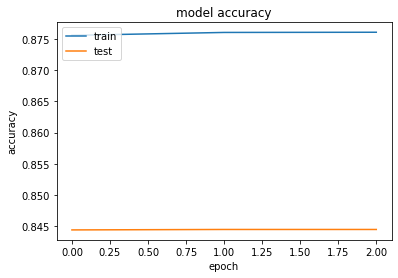

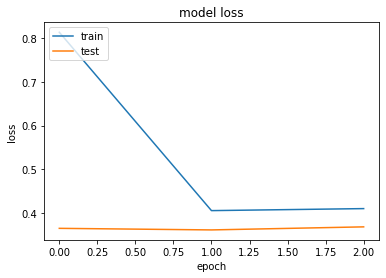

In [38]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading the model previously trained

In [3]:
model = tf.keras.models.load_model('good_different5_model.h5')

In [3]:
# Using subjects 4 and 10, which were not used for the training and validation.
files_test = []
files_test.append(open("../dataset_fog_release/dataset/S04R01.txt"))
files_test.append(open("../dataset_fog_release/dataset/S10R01.txt"))

# Récupération des 9 valeurs (3 par accéléromètre)
# Do we need to duplicate the data so that we can have a moving frame with a step of one second? (one frame of 2 sec every 1 sec)
i=0
interval_counter = 0
nb_validation_samples = 0
all_time_test = []
all_truth_test = []
all_data_test = []


# An array containing the sequence of the last 128 rows of data.
last_time_seq = []
last_data_seq = []

for f in files_test:
    
    time = []
    truth = []
    data = []
    for line in f:
        str_values = line.split()
        values = [[int(nb)] for nb in str_values]

        ground_truth = values.pop(10)
        
        # In the dataset, 0 is considered as a "not part of the experiment".
        if ground_truth[0] != 0:
            
            if i >= 128:
                # We remove the first line
                last_time_seq.pop(0)
                last_data_seq.pop(0)
            
            # Adding truth, time and data for this line
            last_time_seq.append(values.pop(0))
            last_truth_seq = ground_truth[0] - 1
            last_data_seq.append(values)

            if i >= 128 and interval_counter >= 8:
                # We add this sequence to the dataset:
                time.append(copy.deepcopy(last_time_seq))
                truth.append(copy.deepcopy(last_truth_seq))
                data.append(copy.deepcopy(last_data_seq))
                nb_validation_samples +=1
                interval_counter = 0
            interval_counter += 1
            i+=1
            
    all_time_test+=time
    all_truth_test+=truth
    all_data_test+=data
            

print(len(all_time_test))
print(len(all_data_test))
print(len(all_truth_test))


34385
34385
34385


In [39]:
results = model.evaluate(all_data_test, all_truth_test)
print('test loss, test acc:', results)

34385/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss, test acc: [0.09106957738796811, 1.0]


## Generating model for TensorflowLite

#### Getting sample data to make a representative dataset for the conversion into *tflite* model

In [5]:
# Using subject 10, which was not used for the training and validation.

file = open("../dataset_fog_release/dataset/S10R01.txt")

i=0
interval_counter = 0
nb_samples = 0

# An array containing the sequence of the last 128 rows of data.
last_time_seq = []
last_data_seq = []

sample_time = []
sample_truth = []
sample_data = []

# Looking for one input sample:
for line in file:
    """
    # If we already collected the sample data, we stop
    if nb_samples == 1:
        break;
    """
    
    # Cutting the line into array of values
    str_values = line.split()
    values = [[int(nb)] for nb in str_values]
    
    # We get the ground truth by removing it from the values
    ground_truth = values.pop(10)

    # In the dataset, 0 is considered as a "not part of the experiment".
    if ground_truth[0] != 0:
        
        # Because we want 128 record per sample, we remove the first line each time we exceed this number
        if i >= 128:
            # We remove the first line
            last_time_seq.pop(0)
            last_data_seq.pop(0)

        # Adding truth, time and data for this line in the sequence
        last_time_seq.append(values.pop(0))
        last_truth_seq = ground_truth[0] - 1
        last_data_seq.append(values)

        if i >= 128 and interval_counter >= 8:
            # We add this sequence to the dataset:
            sample_time.append(copy.deepcopy(last_time_seq))
            sample_truth.append(copy.deepcopy(last_truth_seq))
            sample_data.append(copy.deepcopy(last_data_seq))
            
            nb_samples +=1
            interval_counter = 0
            
        interval_counter += 1
        i+=1

print(len(sample_time))
print(len(sample_truth))
print(len(sample_data))


17825
17825
17825


#### Converting into the *tflite* model

In [17]:
# Provide a representative dataset
def representative_dataset_gen():
  for i in range(num_calibration_steps):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [sample_data[i]]

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()

open("tflite_quant_model.tflite", "wb").write(tflite_quant_model)

302520

model.save_weights('training2.w')

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding="same", activation='relu', input_shape=(9, 128, 1)))

model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(1024, (3, 5), activation='relu'))

#Full Connection:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

train_dataset = tf.data.Dataset.from_tensor_slices(([all_data[0]], [all_truth[0]]))
test_dataset = tf.data.Dataset.from_tensor_slices((all_data_validation, all_truth_validation))

history = model.fit_generator(
            train_dataset,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=test_dataset,
            validation_steps=nb_validation_samples // batch_size)

history = model.fit_generator(
            (all_data[0], all_truth[0]),
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=(all_data_validation, all_truth_validation),
            validation_steps=nb_validation_samples // batch_size)

In [24]:
"""
j = 0
for i in all_data_test:
    if j < 50:
        for idata in i:
            print(idata)
        print("---------------")
        j += 1
"""

j = 0
for i in all_truth_test:
    if i == 1:
        print("coucou")


#print(all_time.shape)
#print(all_data.shape)
#print(all_truth.shape)


print("all_time: ")
print(len(all_time))

print("")
print("all_data: ")
print(len(all_data))
print("all_data[0]: ")
print(len(all_data[0]))
print("all_data[0][0]: ")
print(len(all_data[0][0]))
print("all_data[0][0][0]: ")
print(len(all_data[0][0][0]))
print("all_data[0][0][0][0]: ")
print(len(all_data[0][0][0][0]))

print("")
print("all_truth: ")
print(len(all_truth))
print("all_truth[0]: ")
print(len(all_truth[0]))
print("all_truth[0][0]: ")
print(all_truth[0][0])
print(len(all_truth[0][0]))

print("")
print("all_data_validation: ")
print(len(all_data_validation[0]))
print(len(all_data_validation[0][0]))
print(len(all_data_validation[0][0]))
print(len(all_data_validation[0][0][0]))

"""
a = np.array([])
print(a)
np.append(a, [[1,2,3]])
print(a)
np.append(a, [[4,5,6]])
print(a)"""

## Looking for max and min values in the accelerometer values

In [5]:
# Opening the dataset
files = []
files.append(open("../dataset_fog_release/dataset/S01R01.txt"))
files.append(open("../dataset_fog_release/dataset/S01R02.txt"))

files.append(open("../dataset_fog_release/dataset/S02R01.txt"))
files.append(open("../dataset_fog_release/dataset/S02R02.txt"))
files.append(open("../dataset_fog_release/dataset/S03R01.txt"))
files.append(open("../dataset_fog_release/dataset/S03R02.txt"))
files.append(open("../dataset_fog_release/dataset/S03R03.txt"))

# Removing subjects 4 and 10 as they did not experience any FOG.
files.append(open("../dataset_fog_release/dataset/S04R01.txt"))

files.append(open("../dataset_fog_release/dataset/S05R01.txt"))
files.append(open("../dataset_fog_release/dataset/S05R02.txt"))
files.append(open("../dataset_fog_release/dataset/S06R01.txt"))
files.append(open("../dataset_fog_release/dataset/S06R02.txt"))
files.append(open("../dataset_fog_release/dataset/S07R01.txt"))
files.append(open("../dataset_fog_release/dataset/S07R02.txt"))
files.append(open("../dataset_fog_release/dataset/S08R01.txt"))

files.append(open("../dataset_fog_release/dataset/S10R01.txt"))
files.append(open("../dataset_fog_release/dataset/S09R01.txt"))

# Looking for max and min values:
maxV = -10000000
minV =  10000000

for i in files:
    for line in i:
        
        str_values = line.split()
        values = [int(nb) for nb in str_values]
        
        # Removing timestamp and truth
        values.pop(0)
        values.pop(9)
        
        for v in values:
            if v > maxV:
                maxV = v
            if v < minV:
                minV = v


In [6]:
print("max: {}".format(maxV))
print("min: {}".format(minV))

max: 32598
min: -32763
